# Task Topic: Fashion-MNIST

## Task:

Train CNN network(s) which reach(es) accuracies around 95% on the Fashion-MNIST dataset (https://github.com/zalandoresearch/fashion-mnist), still efficient for the task (not to much time and hardware specs).

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

# Import the necessary packages from Keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras.optimizers import SGD, RMSprop, Adagrad, Adadelta, Adam, Adamax, Nadam
from keras.datasets import fashion_mnist
from keras.preprocessing.image import ImageDataGenerator
from keras import callbacks

# Import necessary Python built-ins
import time
import os

# Import other necessary packages
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


Using TensorFlow backend.


I will implement several CNN tuning some of the hyperparameters, but for simplicity and based on some experienced, and also because of training time and hardware limitations, I will keep an archictecture consisting of:
    
    - 2 Conv Layers with X filters + DropOut with alpha probability
    - 2 Conv Layers with Y filters + DropOut with beta probability
    - 1 FullConnected Layer with Z neurons + DropOut with gamma probability

and, for simplicity and suitable configuration, I will be using these fixed  hyperparameters / architecture
configurations for all of them:
    
    - Fixed kernel sized: size of the kernel for convolutions
    - Fixed strides: defines how many pixels to move for next convolution
    - Padding: to keep same input-ouput size after convolutions
    - ReLu activations: helps to alleviate the vanishing and exploding gradient problem
    - Fixed pool size: downsampling for reducing the spatial dimension, and also helps avoid overfitting
    - BatchNormalization: Improves stability, simplifies hyperparameters tuning, and reduces number of epochs (at the expense of an increase in per-epoch time)
    - DropOut: regularization technique that prevents overfitting
    - Kernel Initializer: sets the initial values of the weights (based on some random distribution)
    - Final SoftMax Activation: For multi-class classification

In [2]:
## MODEL ARCHITECTURE CLASS

class MiniVGGNet:
    @staticmethod
    def build(width, height, depth, classes, first_cv_filters, second_cv_filters,
              first_cv_dropout, second_cv_dropout, fc_nodes, fc_dropout):
        # initialize the model along with the input shape to be
        # "channels last" and the channels dimension itself
        model = Sequential()
        inputShape = (height, width, depth)
        chanDim = -1

        # if we are using "channels first", update the input shape
        # and channels dimension
        if K.image_data_format() == "channels_first":
            inputShape = (depth, height, width)
            chanDim = 1

        # These are the hyperparameters that I will not be tuning
        kernel_size = (3, 3)
        strides = (1, 1)
        padding = "same"
        activation = "relu"
        pool_size = (2, 2)
        use_bias = False # No need for bias when using BatchNormalization
        kernel_initializer = 'glorot_uniform' # http://jmlr.org/proceedings/papers/v9/glorot10a/glorot10a.pdf
        # kernel_initializer = 'glorot_normal' # http://jmlr.org/proceedings/papers/v9/glorot10a/glorot10a.pdf
        # kernel_initializer = 'he_uniform' # http://arxiv.org/aMINI_BATCH_SIZE/1502.01852
        # kernel_initializer = 'he_normal' # http://arxiv.org/aMINI_BATCH_SIZE/1502.01852
        # kernel_initializer = 'variance_scaling' # http://arxiv.org/aMINI_BATCH_SIZE/1312.6120

        # first CONV => RELU => CONV => RELU => POOL layer set
        model.add(Conv2D(filters=first_cv_filters, kernel_size=kernel_size, strides=strides,
                         padding=padding, activation=activation, use_bias=use_bias,
                         kernel_initializer=kernel_initializer,
                         input_shape=inputShape))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(filters=first_cv_filters, kernel_size=kernel_size, strides=strides,
                         padding=padding, activation=activation, use_bias=use_bias,
                         kernel_initializer=kernel_initializer))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=pool_size))
        model.add(Dropout(first_cv_dropout))

        # second CONV => RELU => CONV => RELU => POOL layer set
        model.add(Conv2D(filters=second_cv_filters, kernel_size=kernel_size, strides=strides,
                         padding=padding, activation=activation, use_bias=use_bias,
                         kernel_initializer=kernel_initializer))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(filters=second_cv_filters, kernel_size=kernel_size, strides=strides,
                         padding=padding, activation=activation, use_bias=use_bias,
                         kernel_initializer=kernel_initializer))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=pool_size))
        model.add(Dropout(second_cv_dropout))

        # first (and only) set of FC => RELU layers
        model.add(Flatten())
        model.add(Dense(fc_nodes))
        model.add(Activation(activation))
        model.add(BatchNormalization())
        model.add(Dropout(fc_dropout))

        # softmax classifier
        model.add(Dense(classes))
        model.add(Activation("softmax")) # multi-class classification

        # return the constructed network architecture
        return model

Now, we will load the Fashion-MNIST dataset, and configuring some variables that we will use later

In [3]:
## DATASET CONFIGURATION

# Load and configure Dataset
print("[INFO] loading Fashion MNIST...")
((trainX, trainY), (testX, testY)) = fashion_mnist.load_data()

# Class names (not in load_data)
labelNames = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
              'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Dataset parameters
width = 28
height = 28
depth = 1
numLabels = len(labelNames)

# num_samples x depth x rows x columns
if K.image_data_format() == "channels_first":
    trainX = trainX.reshape((trainX.shape[0], 1, height, width))
    testX = testX.reshape((testX.shape[0], 1, height, width))
# num_samples x rows x columns x depth
else:
    trainX = trainX.reshape((trainX.shape[0], height, width, 1))
    testX = testX.reshape((testX.shape[0], height, width, 1))


[INFO] loading Fashion MNIST...


In order to train a good model, but not spend too much time looking for the best one, I will first train several models with a small number of epochs, and changing some hyperparameters between them. This will give me an idea of which configuration could work best for this particular problem. Later, I will train a model with those hyperparameters, but increasing the number of epochs (and checking if it doesn't start overfittig)

For this reason, I will split the original train-set in two sets: subtrain and eval. I will be evaluating these pre-models with the eval-set, and finally I will train the final model with the original train-set, and test it with the test-set.

In [4]:
validation_split = 0.1666

# Split train in (sub)train and eval
subtrainX, evalX, subtrainY, evalY = train_test_split(trainX, trainY, test_size=validation_split)

All of the pre-models will be trained with the same number of epochs and mini-batch-size

In [5]:
NUM_EPOCHS = 10
MINI_BATCH_SIZE = 32

Now, I will be training several models with different strategies, based on:

    - architecture: changing the number of filters and dropout probabilities
    - optimizers: changing between some optimizers that are implemented in Keras
    - data-augmentation: changing the brightness of the input images
    
As for the data-augmentation strategy, looking at the dataset, it seems that all of the images are already centered, with fixed sizes, aligned, etc. So shifting, flipping, shearing and zooming wouldn't be correct. But they do change in brightness. So I will be making data-augmentation based only on this last variable, but trying different values.

In [8]:
# These are the hyperparameters that I will be tuning for the architecture
architectures = {
                 "A": {"first_cv_filters": 32, "second_cv_filters": 64, "first_cv_dropout": 0.25, "second_cv_dropout": 0.25, "fc_nodes": 512, "fc_dropout": 0.5},
                 "B": {"first_cv_filters": 32, "second_cv_filters": 64, "first_cv_dropout": 0.5, "second_cv_dropout": 0.5, "fc_nodes": 512, "fc_dropout": 0.5},
                 "C": {"first_cv_filters": 32, "second_cv_filters": 64, "first_cv_dropout": 0.5, "second_cv_dropout": 0.5, "fc_nodes": 512, "fc_dropout": 0.7}
                 }

# These are the optimizers that I will be selecting
INIT_LEARNING_RATE = 1e-2
optimizers = {"Adagrad": Adagrad(), # http://www.jmlr.org/papers/volume12/duchi11a/duchi11a.pdf
              "Adadelta": Adadelta(), # https://arxiv.org/abs/1212.5701
              "Adam": Adam(), # https://arxiv.org/abs/1412.6980v8
              "Adamax": Adamax(),
              "Nadam": Nadam() #http://cs229.stanford.edu/proj2015/054_report.pdf
              }

# I will be doing DataAugmentation based on brightness.
data_augs = {"OFF": 0,
             "5x_0.9_1.1": {"mult": 5, "from": 0.9, "to": 1.1},
             "10x_0.9_1.1": {"mult": 10, "from": 0.9, "to": 1.1},
             "5x_0.7_1.3": {"mult": 5, "from": 0.7, "to": 1.3},
             "10x_0.7_1.3": {"mult": 10, "from": 0.7, "to": 1.3},
             "5x_0.5_1.5": {"mult": 5, "from": 0.5, "to": 1.5},
             "10x_0.5_1.5": {"mult": 10, "from": 0.5, "to": 1.5}
             }

results = []

After some small training I have made (not showed here), I decided to keep the C architecture, with Nadam optimizer, and data augmentation. Now I will train the same model, but with more epochs.

In [10]:
NUM_EPOCHS = 10
ARCHITECTURE = "C"
OPTIMIZER = "Nadam"
DATA_AUG = "10x_0.7_1.3"


In [11]:
print("[INFO] compiling model...")

# define model
model = MiniVGGNet.build(width=width,
                         height=height,
                         depth=depth,
                         classes=numLabels,
                         first_cv_filters=architectures[ARCHITECTURE]["first_cv_filters"],
                         second_cv_filters=architectures[ARCHITECTURE]["second_cv_filters"],
                         first_cv_dropout=architectures[ARCHITECTURE]["first_cv_dropout"],
                         second_cv_dropout=architectures[ARCHITECTURE]["second_cv_dropout"],
                         fc_nodes=architectures[ARCHITECTURE]["fc_nodes"],
                         fc_dropout=architectures[ARCHITECTURE]["fc_dropout"])

model.compile(loss="sparse_categorical_crossentropy", # multi-class classification
              optimizer=optimizers[OPTIMIZER],
              metrics=["accuracy"] # same number of examples for each class
              )

# model summary
model.summary()

# train the network
print("[INFO] training model...")

dataaug_train_gen = ImageDataGenerator(rescale=1. / 255, brightness_range=[data_augs[DATA_AUG]["from"],
                                                                           data_augs[DATA_AUG]["to"]])
dataaug_eval_gen = ImageDataGenerator(rescale=1. / 255)
# dataaug_train_gen.fit(subtrainX)
# dataaug_eval_gen.fit(evalX)
train_aug_it = dataaug_train_gen.flow(trainX, trainY, batch_size=MINI_BATCH_SIZE)
test_aug_it = dataaug_eval_gen.flow(testX, testY, batch_size=MINI_BATCH_SIZE)

# using checkpoints
# include the epoch in the file name. (uses `str.format`)
checkpoint_path = "./checkpoints/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
# Create checkpoint callback
cp_callback = callbacks.ModelCheckpoint(checkpoint_path,
                                        save_weights_only=True, # as I know the model architecture, I can save the weights only
                                        period=1, # every 1 epoch (default)
                                        verbose=1)
model.save_weights(checkpoint_path.format(epoch=0))

H = model.fit_generator(train_aug_it,
                        validation_data=test_aug_it,
                        steps_per_epoch=((data_augs[DATA_AUG]["mult"]*len(trainX)) / MINI_BATCH_SIZE),
                        epochs=NUM_EPOCHS, shuffle=True,
                        validation_steps=len(testX) / MINI_BATCH_SIZE,
                        verbose=1,
                        use_multiprocessing=True,
                        callbacks=[cp_callback])  # pass callback to training


[INFO] compiling model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        288       
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        9216      
_________________________________________________________________
batch_normalization_2 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)   

Now we can evaluate the model with our test-set:

In [12]:
train_loss, train_acc = model.evaluate(trainX.astype("float32") / 255.0, trainY, verbose=0)
test_loss, test_acc = model.evaluate(testX.astype("float32") / 255.0, testY, verbose=0)

In [13]:
print('Train accuracy [%]: {0:.2f}'.format(train_acc*100))
print('Test accuracy [%]: {0:.2f}'.format(test_acc*100))
print('Bias [%]: {0:.2f}'.format((1-train_acc)*100))
print('Variance [%]: {0:.2f}'.format(((1-test_acc) - (1-train_acc))*100))

Train accuracy [%]: 98.39
Test accuracy [%]: 94.29
Bias [%]: 1.61
Variance [%]: 4.10


We see that the Bias error is small, but we still have some Variance. So the model is overfitting the dataset. Let's see some plots to understand better what is happening.

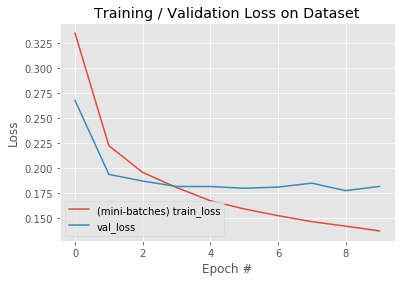

In [14]:
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, NUM_EPOCHS), H.history["loss"], label="(mini-batches) train_loss")
plt.plot(np.arange(0, NUM_EPOCHS), H.history["val_loss"], label="val_loss")
plt.title("Training / Validation Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig("loss_plot.png")


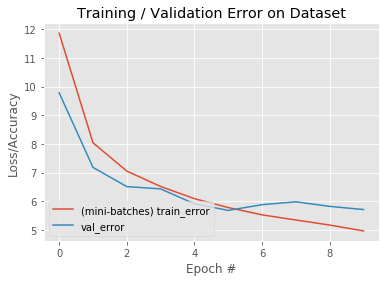

In [15]:
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, NUM_EPOCHS), 100*(1-np.array(H.history["acc"])), label="(mini-batches) train_error")
plt.plot(np.arange(0, NUM_EPOCHS), 100*(1-np.array(H.history["val_acc"])), label="val_error")
plt.title("Training / Validation Error on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("error_plot.png")


So after epoch number 6, the model started to overfit. So, I will keep that checkpoint instead of the final model.

In [16]:
checkpoint_path = "./checkpoints/cp-0006.ckpt"
model.load_weights(checkpoint_path)

In [17]:
train_loss, train_acc = model.evaluate(trainX.astype("float32") / 255.0, trainY, verbose=0)
test_loss, test_acc = model.evaluate(testX.astype("float32") / 255.0, testY, verbose=0)

In [18]:
print('Train accuracy [%]: {0:.2f}'.format(train_acc*100))
print('Test accuracy [%]: {0:.2f}'.format(test_acc*100))
print('Bias [%]: {0:.2f}'.format((1-train_acc)*100))
print('Variance [%]: {0:.2f}'.format(((1-test_acc) - (1-train_acc))*100))

Train accuracy [%]: 97.46
Test accuracy [%]: 94.32
Bias [%]: 2.54
Variance [%]: 3.14


So it seems that this model could probably not improve with more epochs, as it is overfitting the dataset. For next epochs we could try improving our regularization techniques, for example increasing the dropout probabilities or the data-augmentation values.

But for now let's stay with this model. We can see in which classes the model performs better or worse:

In [19]:
print("[INFO] evaluating network...")
preds = model.predict(testX.astype("float32") / 255.0, verbose=0)
print(classification_report(testY, preds.argmax(axis=1), target_names=labelNames))

[INFO] evaluating network...
              precision    recall  f1-score   support

 T-shirt/top       0.90      0.90      0.90      1000
     Trouser       1.00      0.99      0.99      1000
    Pullover       0.93      0.91      0.92      1000
       Dress       0.92      0.96      0.94      1000
        Coat       0.90      0.92      0.91      1000
      Sandal       0.99      0.99      0.99      1000
       Shirt       0.85      0.81      0.83      1000
     Sneaker       0.97      0.98      0.98      1000
         Bag       0.99      0.99      0.99      1000
  Ankle boot       0.98      0.97      0.98      1000

   micro avg       0.94      0.94      0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000



(So T-shirts, pullovers, coats and shirts are the things that the model most missclassifies, which sounds reasonable as they are, from the dataset, the most similar things to the eyes)

And finally, save it to a .h5 file (complete model, with architecture, weights, etc)

In [20]:
# save model
model.save('./model/final_model.h5')